<h1>Training Model</h1>

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForQuestionAnswering
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

E:\Code\seniorProject\aiModels\languageModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
df = pd.read_csv('emotions.csv/emotions.csv')
df

text  label
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416804  i feel like telling these horny devils to find...      2
416805  i began to realize that when i was feeling agi...      3
416806  i feel very curious be why previous early dawn...      5
416807  i feel that becuase of the tyranical nature of...      3
416808  i think that after i had spent some time inves...      5

[416809 rows x 2 columns]

In [34]:
# df = pd.read_csv('archive/tweet_emotions.csv')
# df.loc[df['sentiment'].isin(['happiness','fun','love','enthusiasm']), 'sentiment'] = 'happiness'
# df.loc[df['sentiment'].isin(['sadness']), 'sentiment'] = 'sadness'
# df.loc[df['sentiment'].isin(['worry']), 'sentiment'] = 'fear'
# df.loc[df['sentiment'].isin(['anger','hate']), 'sentiment'] = 'anger'
# df.loc[df['sentiment'].isin(['empty']), 'sentiment'] = 'disgust'
# df.loc[df['sentiment'].isin(['surprise']), 'sentiment'] = 'surprise'
# df.loc[df['sentiment'].isin(['neutral','boredom','relief']), 'sentiment'] = 'neutral'
# emotionsList = df['sentiment'].unique().tolist()
# emotionToLabel = label_map = {label: i for i, label in enumerate(emotionsList)}
# emotionsList, emotionToLabel

(['disgust', 'sadness', 'happiness', 'neutral', 'fear', 'surprise', 'anger'],
 {'disgust': 0,
  'sadness': 1,
  'happiness': 2,
  'neutral': 3,
  'fear': 4,
  'surprise': 5,
  'anger': 6})

In [3]:
df["label"].value_counts()
emotionsList = ["sadness", "joy", "love", "anger", "fear", "surprise"]
# emotionToLabel = {label: i for i, label in enumerate(emotionsList)}
# emotionToLabel[1]

In [4]:
counts = df["label"].value_counts()
classWeights = 1 / counts
classWeights = torch.tensor(
    [classWeights[label] for label in range(len(emotionsList))],
    dtype=torch.float
).to(device)
classWeights = classWeights / classWeights.sum() * len(classWeights)
classWeights


tensor([0.3312, 0.2845, 1.1617, 0.7003, 0.8413, 2.6810], device='cuda:0')

In [86]:
# for label, w in zip(emotionToLabel, classWeights):
#     print(label, float(w))
# for i in range(10):
#     print(df.iloc[i]["content"])
#     print(df.iloc[i]["sentiment"])
#     print(emotionToLabel[df.iloc[i]["sentiment"]])
#     print("------")

In [5]:
dfLength = len(df)
for emotion in range(len(emotionsList)):
    numOfText = len(df.loc[df['label'] == emotion])
    percentageOfTotal = len(df.loc[df['label'] == emotion])/dfLength
    print(f"number of {emotionsList[emotion]} tweets: {numOfText} ({percentageOfTotal*100:.2f}%)")

number of sadness tweets: 121187 (29.07%)
number of joy tweets: 141067 (33.84%)
number of love tweets: 34554 (8.29%)
number of anger tweets: 57317 (13.75%)
number of fear tweets: 47712 (11.45%)
number of surprise tweets: 14972 (3.59%)


In [6]:
trainFraction = 0.8
sampleDf = df.sample(frac=1.0, replace=False, random_state=42)
trainingDataset = sampleDf.sample(frac=trainFraction, replace=False, random_state=42)
validDataset = sampleDf.drop(trainingDataset.index)

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
encodingsTraining = tokenizer(
    trainingDataset['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)

labelsOfEncodingsTraining = torch.tensor(trainingDataset['label'].tolist(), dtype=torch.long)
# labelsOfEncodingsTraining = torch.tensor([emotionToLabel[e] for e in trainingDataset['sentiment'].tolist()], dtype=torch.long)
labelsOfEncodingsTraining

In [18]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
classifier = nn.Sequential(
    nn.Linear(bert.config.hidden_size, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(emotionsList)))
classifier.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
)

In [11]:
trainData = list(zip(encodingsTraining["input_ids"], encodingsTraining["attention_mask"], labelsOfEncodingsTraining))
trainData

[(tensor([  101,  1045,  2018,  1037, 11265, 10976,  6098,  2000,  2175,  2000,
           1045,  2052,  2514, 17772,  2066,  2672,  2023,  2051, 21981,  2424,
           1037,  2126,  2000,  3288,  2026,  2166,  2067,  2000,  2070,  3671,
           5666,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  tensor(1)),
 (tensor([  101, 10047,  3110, 29179, 25956,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

In [12]:
def collate(batch):
    input_ids, masks, labels = zip(*batch)
    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(masks),
        "labels": torch.stack(labels)
    }

In [13]:
trainloader = DataLoader(trainData, batch_size=32, shuffle=True, collate_fn=collate)
trainloader

In [14]:
encodingsValid = tokenizer(
    validDataset['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)

labelsOfEncodingsValid = torch.tensor(validDataset['label'].tolist(), dtype=torch.long)

validData = list(zip(encodingsValid["input_ids"], encodingsValid["attention_mask"], labelsOfEncodingsValid))

validloader = DataLoader(validData, batch_size=32, shuffle=False, collate_fn=collate)
validloader

In [15]:
batch = next(iter(trainloader))
out = bert(batch["input_ids"].to(device), batch["attention_mask"].to(device))
logits = classifier(out.pooler_output)
logits.shape

torch.Size([32, 6])

In [16]:
criterion = nn.CrossEntropyLoss(weight=classWeights)
# optimizer = AdamW([
#     {"params": classifier.parameters(), "lr": 5e-4},
#     {"params": filter(lambda p: p.requires_grad, bert.parameters()), "lr": 2e-5}
# ])

In [56]:
#Bert freezing for overfitting
for parameter in bert.parameters():
    parameter.requires_grad = False

optimizer = AdamW(classifier.parameters(), lr=5e-4)

In [18]:
epochs = 10
bert_train_epochs = 2

epoch_losses = []
epoch_accuracies = []

def trainEmotionRecognition(epochs):

    optimizer = AdamW([
        {"params": classifier.parameters(), "lr": 5e-4},
        {"params": bert.parameters(), "lr": 2e-5}
    ])

    for epoch in range(epochs):

        # Freeze BERT after N epochs
        if epoch == bert_train_epochs:
            for param in bert.parameters():
                param.requires_grad = False

            # Rebuild optimizer ONCE without BERT
            optimizer = AdamW([
                {"params": classifier.parameters(), "lr": 5e-4}
            ])

        bert.train()
        classifier.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0


        for batch_idx, batch in enumerate(trainloader):
            optimizer.zero_grad()

            # Move tensors to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = bert(input_ids, attention_mask)
            logits = classifier(outputs.pooler_output)

            # Compute loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

            # Compute batch accuracy
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels).sum().item()
            batch_accuracy = correct / labels.size(0)

            total_correct += correct
            total_samples += labels.size(0)

            # Print batch stats
            print(f"Epoch {epoch+1}, Batch {batch_idx+1} | Loss: {loss.item():.4f} | Accuracy: {batch_accuracy:.4f}")

        # Print epoch summary
        epoch_loss = total_loss / len(trainloader)
        epoch_acc = total_correct / total_samples

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)

        print(f"--- Epoch {epoch+1} Summary --- Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}\n")

trainEmotionRecognition(epochs)

Epoch 1, Batch 1 | Loss: 1.8167 | Accuracy: 0.0625
Epoch 1, Batch 2 | Loss: 1.7591 | Accuracy: 0.2500
Epoch 1, Batch 3 | Loss: 1.7665 | Accuracy: 0.3750
Epoch 1, Batch 4 | Loss: 1.8237 | Accuracy: 0.3750
Epoch 1, Batch 5 | Loss: 1.8909 | Accuracy: 0.2188
Epoch 1, Batch 6 | Loss: 1.9097 | Accuracy: 0.1562
Epoch 1, Batch 7 | Loss: 1.8013 | Accuracy: 0.1562
Epoch 1, Batch 8 | Loss: 1.8077 | Accuracy: 0.0938
Epoch 1, Batch 9 | Loss: 1.9070 | Accuracy: 0.0312
Epoch 1, Batch 10 | Loss: 1.7693 | Accuracy: 0.0938
Epoch 1, Batch 11 | Loss: 1.9066 | Accuracy: 0.0312
Epoch 1, Batch 12 | Loss: 1.9182 | Accuracy: 0.0625
Epoch 1, Batch 13 | Loss: 1.7670 | Accuracy: 0.0625
Epoch 1, Batch 14 | Loss: 1.9207 | Accuracy: 0.0625
Epoch 1, Batch 15 | Loss: 1.7290 | Accuracy: 0.3438
Epoch 1, Batch 16 | Loss: 1.7837 | Accuracy: 0.2500
Epoch 1, Batch 17 | Loss: 1.8004 | Accuracy: 0.3125
Epoch 1, Batch 18 | Loss: 1.7161 | Accuracy: 0.3438
Epoch 1, Batch 19 | Loss: 1.8522 | Accuracy: 0.3125
Epoch 1, Batch 20 | L

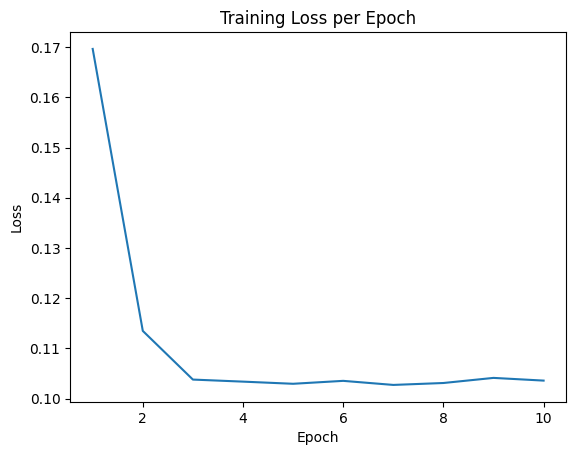

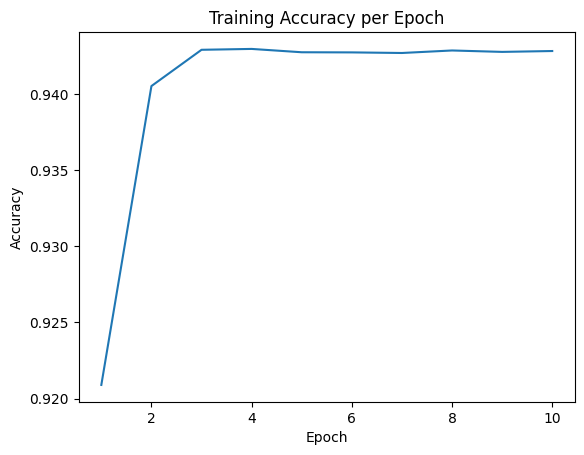

In [19]:
# Loss plot
plt.figure()
plt.plot(range(1, epochs + 1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

# Accuracy plot
plt.figure()
plt.plot(range(1, epochs + 1), epoch_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.show()


In [24]:
def predict_emotion(text):
    # Set to evaluation mode
    bert.eval()
    classifier.eval()

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)

        # Move inputs to device
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        outputs = bert(input_ids, attention_mask)
        logits = classifier(outputs.pooler_output)

        pred = torch.argmax(logits, dim=1).item()

    return emotionsList[pred]

Batch 1 | Loss: 0.1614 | Accuracy: 0.8438
Batch 2 | Loss: 0.1612 | Accuracy: 0.9062
Batch 3 | Loss: 0.1233 | Accuracy: 0.9375
Batch 4 | Loss: 0.0705 | Accuracy: 1.0000
Batch 5 | Loss: 0.0732 | Accuracy: 0.9375
Batch 6 | Loss: 0.0564 | Accuracy: 0.9688
Batch 7 | Loss: 0.1368 | Accuracy: 0.9062
Batch 8 | Loss: 0.0614 | Accuracy: 1.0000
Batch 9 | Loss: 0.0790 | Accuracy: 0.9688
Batch 10 | Loss: 0.1295 | Accuracy: 0.9062
Batch 11 | Loss: 0.0507 | Accuracy: 1.0000
Batch 12 | Loss: 0.1410 | Accuracy: 0.9062
Batch 13 | Loss: 0.0617 | Accuracy: 0.9688
Batch 14 | Loss: 0.0764 | Accuracy: 0.9062
Batch 15 | Loss: 0.0634 | Accuracy: 1.0000
Batch 16 | Loss: 0.0651 | Accuracy: 0.9688
Batch 17 | Loss: 0.1623 | Accuracy: 0.9062
Batch 18 | Loss: 1.7555 | Accuracy: 0.8750
Batch 19 | Loss: 0.0975 | Accuracy: 0.9375
Batch 20 | Loss: 0.1182 | Accuracy: 0.8750
Batch 21 | Loss: 0.1785 | Accuracy: 0.8438
Batch 22 | Loss: 0.0895 | Accuracy: 0.9375
Batch 23 | Loss: 0.0820 | Accuracy: 0.9375
Batch 24 | Loss: 0.0

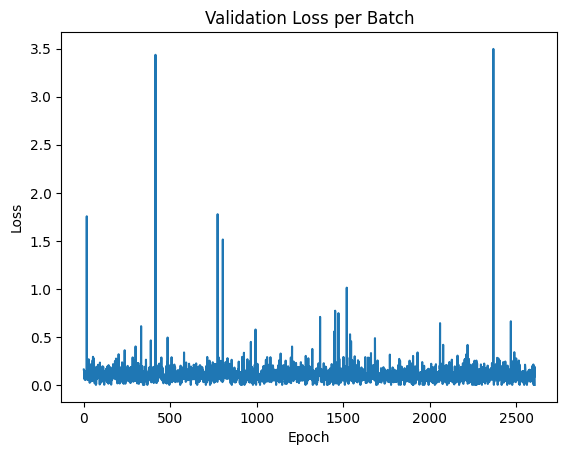

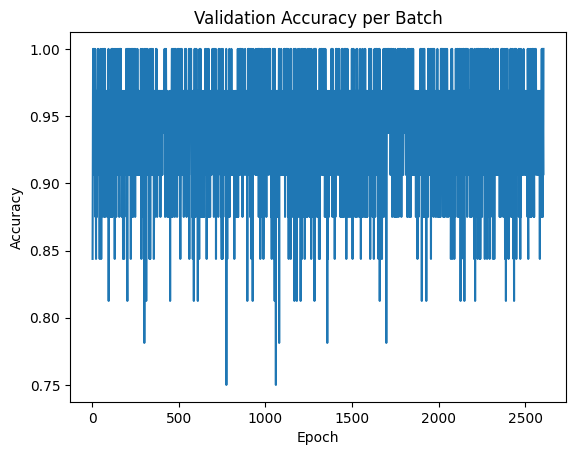

In [23]:
batch_losses = []
batch_accuracies = []
batch_count = len(validloader)

def validateEmotionRecognition():

    bert.eval()
    classifier.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(validloader):
            # Move tensors to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = bert(input_ids, attention_mask)
            logits = classifier(outputs.pooler_output)

            # Compute loss
            loss = criterion(logits, labels)

            # Accumulate loss
            total_loss += loss.item()

            # Compute batch accuracy
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels).sum().item()
            batch_accuracy = correct / labels.size(0)

            # pred_label_id = preds[0].item()
            # true_label_id = labels[0].item()
            #
            # print("Pred:", emotionsList[pred_label_id], pred_label_id)
            # print("True:", emotionsList[true_label_id], true_label_id)
            # print("Text:", tokenizer.decode(input_ids[0], skip_special_tokens=True))

            total_correct += correct
            total_samples += labels.size(0)

            batch_losses.append(loss.item())
            batch_accuracies.append(batch_accuracy)

            # Print batch stats
            print(f"Batch {batch_idx+1} | Loss: {loss.item():.4f} | Accuracy: {batch_accuracy:.4f}")

    # Print epoch summary
    epoch_loss = total_loss / len(validloader)
    epoch_acc = total_correct / total_samples
    print(f"--- Summary --- Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}\n")

validateEmotionRecognition()

# Loss plot
plt.figure()
plt.plot(range(1, batch_count + 1), batch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Batch")
plt.show()

# Accuracy plot
plt.figure()
plt.plot(range(1, batch_count + 1), batch_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Batch")
plt.show()


========== Epoch 1/20 ==========
Train Loss: 0.1730 | Train Acc: 0.9202
Val Loss:   0.1105 | Val Acc:   0.9414

========== Epoch 2/20 ==========
Train Loss: 0.1130 | Train Acc: 0.9405
Val Loss:   0.1081 | Val Acc:   0.9415

========== Epoch 3/20 ==========
🔒 Freezing BERT parameters
Train Loss: 0.1023 | Train Acc: 0.9430
Val Loss:   0.1078 | Val Acc:   0.9415

========== Epoch 4/20 ==========
Train Loss: 0.1027 | Train Acc: 0.9429
Val Loss:   0.1095 | Val Acc:   0.9418

========== Epoch 5/20 ==========
Train Loss: 0.1015 | Train Acc: 0.9432
Val Loss:   0.1089 | Val Acc:   0.9417

========== Epoch 6/20 ==========
Train Loss: 0.1018 | Train Acc: 0.9431
Val Loss:   0.1086 | Val Acc:   0.9417

========== Epoch 7/20 ==========
Train Loss: 0.1014 | Train Acc: 0.9428
Val Loss:   0.1095 | Val Acc:   0.9416

========== Epoch 8/20 ==========
Train Loss: 0.1016 | Train Acc: 0.9430
Val Loss:   0.1091 | Val Acc:   0.9417

========== Epoch 9/20 ==========
Train Loss: 0.1011 | Train Acc: 0.9431
Val 

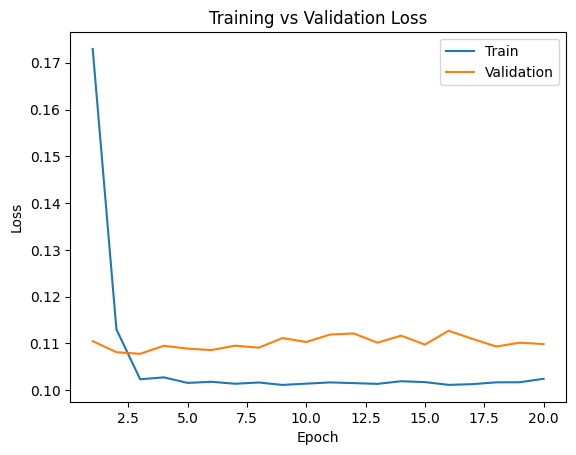

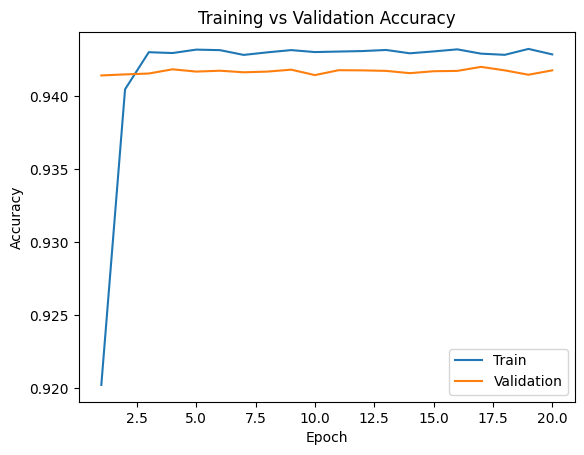

In [20]:
epochs = 10
bert_train_epochs = 2

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


def trainAndValidateEmotionRecognition(epochs):

    optimizer = AdamW([
        {"params": classifier.parameters(), "lr": 5e-4},
        {"params": bert.parameters(), "lr": 2e-5}
    ])

    for epoch in range(epochs):

        print(f"\n========== Epoch {epoch+1}/{epochs} ==========")

        # Freeze BERT after N epochs
        if epoch == bert_train_epochs:
            print("🔒 Freezing BERT parameters")

            for param in bert.parameters():
                param.requires_grad = False

            optimizer = AdamW([
                {"params": classifier.parameters(), "lr": 5e-4}
            ])

        ############################
        # TRAINING
        ############################
        bert.train()
        classifier.train()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch in trainloader:

            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = bert(input_ids=input_ids,
                           attention_mask=attention_mask)

            logits = classifier(outputs.pooler_output)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = total_loss / len(trainloader)
        epoch_train_acc = total_correct / total_samples

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")

        ############################
        # VALIDATION
        ############################
        bert.eval()
        classifier.eval()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch in validloader:

                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = bert(input_ids=input_ids,
                               attention_mask=attention_mask)

                logits = classifier(outputs.pooler_output)

                loss = criterion(logits, labels)

                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                total_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        epoch_val_loss = total_loss / len(validloader)
        epoch_val_acc = total_correct / total_samples

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")

    #################################
    # PLOTS
    #################################

    epochs_range = range(1, epochs + 1)

    # Loss
    plt.figure()
    plt.plot(epochs_range, train_losses, label="Train")
    plt.plot(epochs_range, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs_range, train_accuracies, label="Train")
    plt.plot(epochs_range, val_accuracies, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()


trainAndValidateEmotionRecognition(epochs)

In [38]:
# df.loc[df['text'] == "i forget that im supposed to be sad about being single or stressed about work and just smile and feel peaceful"]

text  label
101120  i forget that im supposed to be sad about bein...      1

In [42]:
predict_emotion("I was so scared last night")

'joy'

In [21]:
torch.save({
    'bert_state_dict': bert.state_dict(),
    'classifier_state_dict': classifier.state_dict(),
}, 'combined_model.pth')

In [10]:
#Load values from pretrained model
checkpoint = torch.load("combined_model.pth", map_location=device)

bert.load_state_dict(checkpoint["bert_state_dict"])
classifier.load_state_dict(checkpoint["classifier_state_dict"])

bert.to(device)
classifier.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
)

<h1>Answering Questions</h1>

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

entry = "My family got attacked, and I'm shaken"
question = "Why do you feel this way?"

def get_segment_ids(indexed_tokens):
    segment_ids = []
    segment_id = 0
    cls_token = 101
    sep_token = 102
    for token in indexed_tokens:
        if token == sep_token:
            segment_id += 1
        segment_ids.append(segment_id)
    segment_ids[-1] -= 1  # Last [SEP] is ignored
    return torch.tensor([segment_ids]), torch.tensor([indexed_tokens])

question_answering_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
indexed_tokens = question_answering_tokenizer.encode(entry, question, add_special_tokens=True)
segments_tensors, tokens_tensor = get_segment_ids(indexed_tokens)

In [23]:
tokens_tensor

tensor([[  101,  2026,  2155,  2288,  4457,  1010,  1998,  1045,  1005,  1049,
         16697,   102,  2339,  2079,  2017,  2514,  2023,  2126,  1029,   102]])

In [52]:
question_answering_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
# Predict the start and end positions logits
with torch.no_grad():
    out = question_answering_model(tokens_tensor, token_type_ids=segments_tensors)
out

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.2218, -2.5223, -4.6879, -5.5563, -4.8046, -6.7331, -5.6946, -3.7598,
         -7.1398, -6.4886, -4.0041, -5.2217, -5.3479, -6.8223, -5.8152, -5.9639,
         -5.6855, -6.2966, -8.1459, -5.2217]]), end_logits=tensor([[-1.7296, -5.7044, -3.7602, -6.0096, -1.6303, -1.6498, -5.4789, -3.6664,
         -6.1352, -4.5078, -2.0237, -1.7295, -5.1804, -6.2002, -4.8869, -5.3965,
         -6.3909, -5.2236, -5.1710, -1.7296]]), hidden_states=None, attentions=None)

In [54]:
out.start_logits
out.end_logits

tensor([[-1.7296, -5.7044, -3.7602, -6.0096, -1.6303, -1.6498, -5.4789, -3.6664,
         -6.1352, -4.5078, -2.0237, -1.7295, -5.1804, -6.2002, -4.8869, -5.3965,
         -6.3909, -5.2236, -5.1710, -1.7296]])

In [55]:
answer_sequence = indexed_tokens[torch.argmax(out.start_logits):torch.argmax(out.end_logits)+1]
answer_sequence

[2026, 2155, 2288, 4457]

In [56]:
question_answering_tokenizer.convert_ids_to_tokens(answer_sequence)

['my', 'family', 'got', 'attacked']

In [57]:
question_answering_tokenizer.decode(answer_sequence)

'my family got attacked'